# Sections of this project!
[Importing Packages][Importing-Packages]

[Importing-Packages]: #Importing-Packages


[Setting-Parameters-for-API-Pull][Setting-Parameters-for-API-Pull]

[Setting-Parameters-for-API-Pull]: #Setting-Parameters-for-API-Pull


[Creating-Function-for-API-pull][Creating-Function-for-API-pull]

[Creating-Function-for-API-pull]: #Creating-Function-for-API-pull

# Importing Packages

In [2]:
# Installing Packages
!{sys.executable} -m pip install nba_api --quiet
!{sys.executable} -m pip install pandas --quiet
!{sys.executable} -m pip install tqdm --quiet

#Importing packages
from nba_api.stats.static import players
from nba_api.stats.endpoints import leaguegamefinder
from nba_api.stats.endpoints import commonplayerinfo
from nba_api.stats.endpoints import playbyplayv2
import requests, pandas as pd, sys
from tqdm import tqdm
import dateutil.parser as parser
import numpy as np
import time
import seaborn as sns
from datetime import datetime,  timedelta

## Setting Pandas option to show all columns

In [333]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 25)

# Creating Function for API pull

### Setting parameters for data pull

In [4]:
#Creating header var for api pull
headers: dict[str, str]  = {
    'Connection': 'keep-alive',
    'Accept': 'application/json, text/plain, */*',
    'x-nba-stats-token': 'true',
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.130 Safari/537.36',
    'x-nba-stats-origin': 'stats',
    'Sec-Fetch-Site': 'same-origin',
    'Sec-Fetch-Mode': 'cors',
    'Referer': 'https://stats.nba.com/',
    'Accept-Encoding': 'gzip, deflate, br',
    'Accept-Language': 'en-US,en;q=0.9',
}

### Function that Pulls API data

In [5]:
# create function that gets pbp (play by play) logs from the 2021-22 season
def get_data(game_id) -> pd.DataFrame:
    play_by_play_url = "https://cdn.nba.com/static/json/liveData/playbyplay/playbyplay_"+game_id+".json"
    response = requests.get(url=play_by_play_url, headers=headers).json()
    play_by_play = response['game']['actions']
    df = pd.DataFrame(play_by_play)
    df['gameid'] = game_id
    return df

### Defining parameters for data pull

In [6]:
gamefinder = leaguegamefinder.LeagueGameFinder(season_nullable='2021-22',
                                               league_id_nullable='00',
                                               season_type_nullable='Regular Season')

## Retrieving Game Ids

## List of unique game ids for 2021-2022 season

In [7]:
games = gamefinder.get_data_frames()[0]
#getting a list of distinct game ids
game_ids = games['GAME_ID'].unique()
len(game_ids)

1230

In [8]:
# Retrieving all game dataframes to get unique game ids
games = gamefinder.get_data_frames()[0]

#getting a list of distinct game ids
game_ids = games['GAME_ID'].unique()

# Setting an empty list for the game information
pbpdata = []

#Here TDQM() creates a % completion bar
for game_id in tqdm(game_ids):
    game_data: pd.DataFrame = get_data(game_id)
    pbpdata.append(game_data)

final_df: pd.DataFrame = pd.concat(pbpdata, ignore_index=True)

100%|██████████| 1230/1230 [05:11<00:00,  3.95it/s]


## Instantiating Data Frame

In [253]:
final_df_copy: pd.DataFrame = pd.DataFrame(final_df)

## Reviewing Column Names

In [10]:
#Primary columns in the DF
final_df_copy.columns

Index(['actionNumber', 'clock', 'timeActual', 'period', 'periodType',
       'actionType', 'subType', 'qualifiers', 'personId', 'x', 'y',
       'possession', 'scoreHome', 'scoreAway', 'edited', 'orderNumber',
       'xLegacy', 'yLegacy', 'isFieldGoal', 'side', 'description',
       'personIdsFilter', 'teamId', 'teamTricode', 'descriptor',
       'jumpBallRecoveredName', 'jumpBallRecoverdPersonId', 'playerName',
       'playerNameI', 'jumpBallWonPlayerName', 'jumpBallWonPersonId',
       'jumpBallLostPlayerName', 'jumpBallLostPersonId', 'turnoverTotal',
       'stealPlayerName', 'stealPersonId', 'shotDistance', 'shotResult',
       'shotActionNumber', 'reboundTotal', 'reboundDefensiveTotal',
       'reboundOffensiveTotal', 'officialId', 'foulPersonalTotal',
       'foulTechnicalTotal', 'foulDrawnPlayerName', 'foulDrawnPersonId',
       'pointsTotal', 'assistPlayerNameInitial', 'assistPersonId',
       'assistTotal', 'value', 'blockPlayerName', 'blockPersonId', 'gameid'],
      dtype='o

In [11]:
final_df_copy.head()

,actionNumber,clock,timeActual,period,periodType,actionType,subType,qualifiers,personId,x,y,possession,scoreHome,scoreAway,edited,orderNumber,xLegacy,yLegacy,isFieldGoal,side,description,personIdsFilter,teamId,teamTricode,descriptor,jumpBallRecoveredName,jumpBallRecoverdPersonId,playerName,playerNameI,jumpBallWonPlayerName,jumpBallWonPersonId,jumpBallLostPlayerName,jumpBallLostPersonId,turnoverTotal,stealPlayerName,stealPersonId,shotDistance,shotResult,shotActionNumber,reboundTotal,reboundDefensiveTotal,reboundOffensiveTotal,officialId,foulPersonalTotal,foulTechnicalTotal,foulDrawnPlayerName,foulDrawnPersonId,pointsTotal,assistPlayerNameInitial,assistPersonId,assistTotal,value,blockPlayerName,blockPersonId,gameid
0,2,PT12M00.00S,2022-04-10T23:17:50.6Z,1,REGULAR,period,start,[],0,NaN,NaN,0,0,0,2022-04-10T23:17:50Z,20000,NaN,NaN,0,None,Period Start,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0022101223
1,4,PT11M57.00S,2022-04-10T23:17:53.3Z,1,REGULAR,jumpball,recovered,[],1627759,NaN,NaN,1610612738,0,0,2022-04-10T23:17:53Z,40000,NaN,NaN,0,None,Jump Ball A. Horford vs. X. Tillman: Tip to J....,"[1627759, 201143, 1630214]",1.610613e+09,BOS,startperiod,J. Brown,1627759.0,Brown,J. Brown,Horford,201143.0,Tillman,1630214.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0022101223
2,7,PT11M44.00S,2022-04-10T23:18:05.8Z,1,REGULAR,turnover,bad pass,[],201143,NaN,NaN,1610612738,0,0,2022-04-10T23:18:10Z,70000,NaN,NaN,0,None,A. Horford bad pass TURNOVER (1 TO),"[201143, 1630214]",1.610613e+09,BOS,NaN,NaN,NaN,Horford,A. Horford,NaN,NaN,NaN,NaN,1.0,Tillman,1630214.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0022101223
3,8,PT11M44.00S,2022-04-10T23:18:05.8Z,1,REGULAR,steal,NaN,[],1630214,NaN,NaN,1610612763,0,0,2022-04-10T23:18:07Z,80000,NaN,NaN,0,None,X. Tillman STEAL (1 STL),[1630214],1.610613e+09,MEM,NaN,NaN,NaN,Tillman,X. Tillman,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0022101223
4,9,PT11M31.00S,2022-04-10T23:18:18.5Z,1,REGULAR,3pt,Jump Shot,[fromturnover],1629001,63.945466,59.313725,1610612763,0,0,2022-04-10T23:18:24Z,90000,47.0,286.0,1,right,MISS D. Melton 29' pullup 3PT,[1629001],1.610613e+09,MEM,pullup,NaN,NaN,Melton,D. Melton,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.02,Missed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0022101223


In [76]:
final_df_copy.describe()

,actionNumber,period,personId,x,y,possession,orderNumber,xLegacy,yLegacy,isFieldGoal,teamId,jumpBallRecoverdPersonId,jumpBallWonPersonId,jumpBallLostPersonId,turnoverTotal,stealPersonId,shotDistance,shotActionNumber,reboundTotal,reboundDefensiveTotal,reboundOffensiveTotal,officialId,foulPersonalTotal,foulTechnicalTotal,foulDrawnPersonId,pointsTotal,assistPersonId,assistTotal,blockPersonId,period_to_time,time_passed_in_seconds
count,691875.000000,691875.000000,6.918750e+05,216713.000000,216713.000000,6.918750e+05,6.918750e+05,216713.000000,216713.000000,691875.000000,6.650260e+05,2.087000e+03,2.183000e+03,2.183000e+03,32102.000000,1.876000e+04,216713.000000,128907.000000,109347.000000,109347.000000,109347.000000,6.832800e+04,49746.000000,49746.000000,4.830600e+04,141587.000000,6.063600e+04,60636.000000,1.160300e+04,691875.000000,691875
mean,338.339700,2.547697,1.031516e+06,49.968831,49.575517,1.604646e+09,3.322918e+06,-2.716113,96.808876,0.313226,1.610613e+09,1.116123e+06,1.029718e+06,1.110913e+06,1.905613,1.155470e+06,14.284271,329.759261,4.023192,3.071653,0.951540,4.515309e+05,1.995055,0.062156,1.095785e+06,9.896961,1.092272e+06,3.094878,1.144186e+06,18.490363,0 days 00:06:16.793656368
std,194.280636,1.128020,7.275118e+05,35.589950,22.923325,9.784667e+07,1.906753e+06,114.604103,95.291674,0.463806,8.643626e+00,6.896156e+05,7.075713e+05,6.887543e+05,1.214381,6.751063e+05,10.578877,196.023594,3.070912,2.462871,1.269107,6.427159e+05,1.130653,0.252112,6.935572e+05,7.440506,6.947680e+05,2.405318,6.794527e+05,13.381325,0 days 00:03:32.717338484
min,2.000000,1.000000,0.000000e+00,0.213535,0.000000,0.000000e+00,2.000000e+04,-250.000000,-51.000000,0.000000,1.610613e+09,2.544000e+03,2.544000e+03,2.544000e+03,1.000000,2.544000e+03,0.000000,3.000000,1.000000,0.000000,0.000000,1.146000e+03,0.000000,0.000000,2.544000e+03,1.000000,2.544000e+03,1.000000,2.544000e+03,0.000000,0 days 00:00:00
25%,170.000000,2.000000,2.030760e+05,11.563732,39.460784,1.610613e+09,1.680000e+06,-53.000000,14.000000,0.000000,1.610613e+09,2.032000e+05,2.035000e+05,2.035165e+05,1.000000,2.035010e+05,3.140000,160.000000,2.000000,1.000000,0.000000,2.005000e+03,1.000000,0.000000,2.034960e+05,4.000000,2.034630e+05,1.000000,2.034970e+05,12.000000,0 days 00:03:21
50%,336.000000,3.000000,1.627759e+06,57.506570,50.000000,1.610613e+09,3.300000e+06,0.000000,57.000000,0.000000,1.610613e+09,1.628366e+06,1.626174e+06,1.627745e+06,1.000000,1.628374e+06,13.940000,329.000000,3.000000,2.000000,1.000000,2.016400e+05,2.000000,0.000000,1.627814e+06,8.000000,1.627826e+06,2.000000,1.628381e+06,24.000000,0 days 00:06:23
75%,503.000000,4.000000,1.629632e+06,88.354139,59.068627,1.610613e+09,4.940000e+06,47.000000,184.000000,1.000000,1.610613e+09,1.629632e+06,1.629011e+06,1.629603e+06,2.000000,1.629655e+06,25.080000,496.000000,5.000000,4.000000,1.000000,2.040580e+05,3.000000,0.000000,1.629630e+06,14.000000,1.629636e+06,4.000000,1.629647e+06,36.000000,0 days 00:09:18
max,893.000000,7.000000,1.630994e+06,99.819317,99.754902,1.610613e+09,8.750000e+06,250.000000,878.000000,1.000000,1.610613e+09,1.630787e+06,1.630846e+06,1.630846e+06,10.000000,1.630994e+06,88.940000,890.000000,25.000000,21.000000,12.000000,1.629422e+06,6.000000,3.000000,1.630994e+06,60.000000,1.630994e+06,19.000000,1.630846e+06,36.000000,0 days 00:12:00


# _Data Manipulation and Formating_

### Checking data types

In [12]:
### Transforming data types
dict(final_df_copy.dtypes)

{'actionNumber': dtype('int64'),
 'clock': dtype('O'),
 'timeActual': dtype('O'),
 'period': dtype('int64'),
 'periodType': dtype('O'),
 'actionType': dtype('O'),
 'subType': dtype('O'),
 'qualifiers': dtype('O'),
 'personId': dtype('int64'),
 'x': dtype('float64'),
 'y': dtype('float64'),
 'possession': dtype('int64'),
 'scoreHome': dtype('O'),
 'scoreAway': dtype('O'),
 'edited': dtype('O'),
 'orderNumber': dtype('int64'),
 'xLegacy': dtype('float64'),
 'yLegacy': dtype('float64'),
 'isFieldGoal': dtype('int64'),
 'side': dtype('O'),
 'description': dtype('O'),
 'personIdsFilter': dtype('O'),
 'teamId': dtype('float64'),
 'teamTricode': dtype('O'),
 'descriptor': dtype('O'),
 'jumpBallRecoveredName': dtype('O'),
 'jumpBallRecoverdPersonId': dtype('float64'),
 'playerName': dtype('O'),
 'playerNameI': dtype('O'),
 'jumpBallWonPlayerName': dtype('O'),
 'jumpBallWonPersonId': dtype('float64'),
 'jumpBallLostPlayerName': dtype('O'),
 'jumpBallLostPersonId': dtype('float64'),
 'turnoverTo

### Creating a new data fame with players removed if they do not play atleast 20 games ///and have more than 10 combined PTS/REB/AST avg per game

In [110]:
# need to group by player and games to take a count of unique game ids a player has been a part of (use player id)
player_games_played: pd.DataFrame = final_df_copy[['gameid','playerNameI', 'personId']].groupby(['personId', 'playerNameI'], as_index=False).nunique().sort_values('gameid', ascending=False)
players_with_20more_games = player_games_played[player_games_played.gameid >= 20].personId

In [305]:
df_players_removed: pd.DataFrame = final_df_copy.query('personId in @players_with_20more_games')

### Creating columns for "Time Passed in Game" and "Date of Game"

In [311]:
# creating a date column
df_players_removed['dateGameStarted'] = pd.to_datetime(df_players_removed.timeActual).dt.date

/var/folders/_l/4wqjn4456n15dy3l1xmxt0nh0000gn/T/ipykernel_3085/1635802243.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players_removed['dateGameStarted'] = pd.to_datetime(df_players_removed.timeActual).dt.date


In [312]:
# Need to use columns:  Period and Clock to determine what time in the game it is (Clock counts down per period)
# period_to_total_time 

# create a fucntion and use map to apply it to the new column

def period_to_time_conversion(value) -> int:

    if value == 1:
        return 0
    elif value == 2:
        return 12
    elif value == 3:
        return 24
    else:
        return 36

In [313]:
df_players_removed['period_to_time'] = df_players_removed['period'].map(period_to_time_conversion)

In [314]:
def time_conversion(unparsed_timearray):
    x = datetime(year =1900, month=1, day=1, hour=0, minute=12, second=0)
    values_array = unparsed_timearray[0:7]
    time_passed_total = x - pd.to_datetime(values_array, format='PT%MM%S')
    return time_passed_total

In [316]:
df_players_removed['time_passed_in_seconds'] = tqdm(df_players_removed['clock'].map(time_conversion))

100%|██████████| 691875/691875 [00:01<00:00, 626552.59it/s]


In [ ]:
#this can be removed it is juts used for checking outputs
df_players_removed

,actionNumber,clock,timeActual,period,periodType,actionType,subType,qualifiers,personId,x,y,possession,scoreHome,scoreAway,edited,orderNumber,xLegacy,yLegacy,isFieldGoal,side,description,personIdsFilter,teamId,teamTricode,descriptor,jumpBallRecoveredName,jumpBallRecoverdPersonId,playerName,playerNameI,jumpBallWonPlayerName,jumpBallWonPersonId,jumpBallLostPlayerName,jumpBallLostPersonId,turnoverTotal,stealPlayerName,stealPersonId,shotDistance,shotResult,shotActionNumber,reboundTotal,reboundDefensiveTotal,reboundOffensiveTotal,officialId,foulPersonalTotal,foulTechnicalTotal,foulDrawnPlayerName,foulDrawnPersonId,pointsTotal,assistPlayerNameInitial,assistPersonId,assistTotal,value,blockPlayerName,blockPersonId,gameid,period_to_time,time_passed_in_seconds
0,2,PT12M00.00S,2022-04-10T23:17:50.6Z,1,REGULAR,period,start,[],0,NaN,NaN,0,0,0,2022-04-10T23:17:50Z,20000,NaN,NaN,0,None,Period Start,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0022101223,0,0 days 00:00:00
1,4,PT11M57.00S,2022-04-10T23:17:53.3Z,1,REGULAR,jumpball,recovered,[],1627759,NaN,NaN,1610612738,0,0,2022-04-10T23:17:53Z,40000,NaN,NaN,0,None,Jump Ball A. Horford vs. X. Tillman: Tip to J....,"[1627759, 201143, 1630214]",1.610613e+09,BOS,startperiod,J. Brown,1627759.0,Brown,J. Brown,Horford,201143.0,Tillman,1630214.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0022101223,0,0 days 00:00:03
2,7,PT11M44.00S,2022-04-10T23:18:05.8Z,1,REGULAR,turnover,bad pass,[],201143,NaN,NaN,1610612738,0,0,2022-04-10T23:18:10Z,70000,NaN,NaN,0,None,A. Horford bad pass TURNOVER (1 TO),"[201143, 1630214]",1.610613e+09,BOS,NaN,NaN,NaN,Horford,A. Horford,NaN,NaN,NaN,NaN,1.0,Tillman,1630214.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0022101223,0,0 days 00:00:16
3,8,PT11M44.00S,2022-04-10T23:18:05.8Z,1,REGULAR,steal,NaN,[],1630214,NaN,NaN,1610612763,0,0,2022-04-10T23:18:07Z,80000,NaN,NaN,0,None,X. Tillman STEAL (1 STL),[1630214],1.610613e+09,MEM,NaN,NaN,NaN,Tillman,X. Tillman,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0022101223,0,0 days 00:00:16
4,9,PT11M31.00S,2022-04-10T23:18:18.5Z,1,REGULAR,3pt,Jump Shot,[fromturnover],1629001,63.945466,59.313725,1610612763,0,0,2022-04-10T23:18:24Z,90000,47.0,286.0,1,right,MISS D. Melton 29' pullup 3PT,[1629001],1.610613e+09,MEM,pullup,NaN,NaN,Melton,D. Melton,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.02,Missed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0022101223,0,0 days 00:00:29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
691870,720,PT00M11.90S,2021-10-20T04:43:25.6Z,4,REGULAR,freethrow,1 of 2,[],2738,NaN,NaN,1610612744,111,120,2021-10-20T04:43:25Z,7080000,NaN,NaN,0,None,A. Iguodala Free Throw 1 of 2 (11 PTS),[2738],1.610613e+09,GSW,NaN,NaN,NaN,Iguodala,A. Iguodala,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Made,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,0022100002,36,0 days 00:11:49
691871,721,PT00M11.90S,2021-10-20T04:43:39.9Z,4,REGULAR,freethrow,2 of 2,[],2738,NaN,NaN,1610612744,111,121,2021-10-20T04:43:39Z,7090000,NaN,NaN,0,None,A. Iguodala Free Throw 2 of 2 (12 PTS),[2738],1.610613e+09,GSW,NaN,NaN,NaN,Iguodala,A. Iguodala,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Made,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,NaN,NaN,NaN,NaN,NaN,NaN,0022100002,36,0 days 00:11:49
691872,722,PT00M07.00S,2021-10-20T04:43:46.4Z,4,REGULAR,3pt,Jump Shot,[],1628370,31.323916,83.578431,1610612747,114,121,2021-10-20T04:44:07Z,7100000,-168.0,242.0,1,left,M. Monk 29' 3PT (6 PTS) (R. Westbrook 4 AST),"[1628370, 201566]",1.610613e+09,LAL,NaN,NaN,NaN,Monk,M. Monk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.45,Made,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,R. Westbrook,201566.0,4.0,NaN,NaN,NaN,00

In [317]:
# Creating a function to create new column with total time passed in game
def total_time_passed(period_finished_minutes, minutes_passed_within_period):
    period_minutes = pd.to_datetime(period_finished_minutes, format='%M')
    minutes_within_period = minutes_passed_within_period
    return period_minutes + minutes_within_period

In [318]:
df_players_removed['Total_time_passed_in_game'] = list(map(total_time_passed, df_players_removed.period_to_time, df_players_removed.time_passed_in_seconds))

In [319]:
#This can be removed as it is juts used for checking outputs
len(df_players_removed[(final_df_copy.gameid == '0022101160') & (df_players_removed.actionType == 'freethrow') & (df_players_removed.playerNameI == 'L. James')])

12

### Preping a mapping dict for player names and Player Ids

In [320]:
#Changing column to int data type
df_players_removed.assistPersonId = final_df_copy.assistPersonId.astype('Int64')

# Creating a dict for mapping object of names and ids
playerid_and_player_initials_dict_assists =dict(zip(df_players_removed.assistPlayerNameInitial.values, df_players_removed.assistPersonId))
playerid_and_player_initials_dict_playername_to_personid =dict(zip(df_players_removed.playerNameI.values, df_players_removed.personId))
playerid_and_player_initials_dict_combined = playerid_and_player_initials_dict_assists | playerid_and_player_initials_dict_playername_to_personid

## Creating data frame object of PlayerNameI, gameid, isFieldGoal, dateGameStarted, pointsTotal, actionType for True Shooting % Analysis

In [321]:
def ts_perc_dataframe_createion(input_dataframe: pd.DataFrame)-> pd.DataFrame:        
        
        df_most_info = input_dataframe\
                .groupby(['playerNameI','gameid','dateGameStarted'], as_index=False)\
                .agg({'isFieldGoal':np.sum,\
                'dateGameStarted':np.min,\
                'pointsTotal': np.max,})

        df_fta = input_dataframe[ ((input_dataframe.actionType == 'freethrow'))]\
                .groupby(['playerNameI','gameid', 'actionType'], as_index=False)['actionType'].count()
                # .agg({'actionType': 'sum'})

        #Merging DFs on columns gameid and playernamei
        combined_df_all_metrics = pd.merge(df_most_info, df_fta, how='left', on=['playerNameI','gameid'])
        
        return combined_df_all_metrics

In [322]:
df_players_removed

,actionNumber,clock,timeActual,period,periodType,actionType,subType,qualifiers,personId,x,y,possession,scoreHome,scoreAway,edited,orderNumber,xLegacy,yLegacy,isFieldGoal,side,description,personIdsFilter,teamId,teamTricode,descriptor,jumpBallRecoveredName,jumpBallRecoverdPersonId,playerName,playerNameI,jumpBallWonPlayerName,jumpBallWonPersonId,jumpBallLostPlayerName,jumpBallLostPersonId,turnoverTotal,stealPlayerName,stealPersonId,shotDistance,shotResult,shotActionNumber,reboundTotal,reboundDefensiveTotal,reboundOffensiveTotal,officialId,foulPersonalTotal,foulTechnicalTotal,foulDrawnPlayerName,foulDrawnPersonId,pointsTotal,assistPlayerNameInitial,assistPersonId,assistTotal,value,blockPlayerName,blockPersonId,gameid,period_to_time,time_passed_in_seconds,Total_time_passed_in_game,dateGameStarted
1,4,PT11M57.00S,2022-04-10T23:17:53.3Z,1,REGULAR,jumpball,recovered,[],1627759,NaN,NaN,1610612738,0,0,2022-04-10T23:17:53Z,40000,NaN,NaN,0,None,Jump Ball A. Horford vs. X. Tillman: Tip to J....,"[1627759, 201143, 1630214]",1.610613e+09,BOS,startperiod,J. Brown,1627759.0,Brown,J. Brown,Horford,201143.0,Tillman,1630214.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0022101223,0,0 days 00:00:03,1900-01-01 00:00:03,2022-04-10
2,7,PT11M44.00S,2022-04-10T23:18:05.8Z,1,REGULAR,turnover,bad pass,[],201143,NaN,NaN,1610612738,0,0,2022-04-10T23:18:10Z,70000,NaN,NaN,0,None,A. Horford bad pass TURNOVER (1 TO),"[201143, 1630214]",1.610613e+09,BOS,NaN,NaN,NaN,Horford,A. Horford,NaN,NaN,NaN,NaN,1.0,Tillman,1630214.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0022101223,0,0 days 00:00:16,1900-01-01 00:00:16,2022-04-10
3,8,PT11M44.00S,2022-04-10T23:18:05.8Z,1,REGULAR,steal,NaN,[],1630214,NaN,NaN,1610612763,0,0,2022-04-10T23:18:07Z,80000,NaN,NaN,0,None,X. Tillman STEAL (1 STL),[1630214],1.610613e+09,MEM,NaN,NaN,NaN,Tillman,X. Tillman,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0022101223,0,0 days 00:00:16,1900-01-01 00:00:16,2022-04-10
4,9,PT11M31.00S,2022-04-10T23:18:18.5Z,1,REGULAR,3pt,Jump Shot,[fromturnover],1629001,63.945466,59.313725,1610612763,0,0,2022-04-10T23:18:24Z,90000,47.0,286.0,1,right,MISS D. Melton 29' pullup 3PT,[1629001],1.610613e+09,MEM,pullup,NaN,NaN,Melton,D. Melton,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.0,Missed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0022101223,0,0 days 00:00:29,1900-01-01 00:00:29,2022-04-10
5,10,PT11M28.00S,2022-04-10T23:18:21.5Z,1,REGULAR,rebound,defensive,[],1628464,NaN,NaN,1610612738,0,0,2022-04-10T23:18:24Z,100000,NaN,NaN,0,None,D. Theis REBOUND (Off:0 Def:1),[1628464],1.610613e+09,BOS,NaN,NaN,NaN,Theis,D. Theis,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0022101223,0,0 days 00:00:32,1900-01-01 00:00:32,2022-04-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
691868,717,PT00M18.60S,2021-10-20T04:42:51.9Z,4,REGULAR,2pt,DUNK,[pointsinthepaint],201566,9.641919,49.509804,1610612747,111,119,2021-10-20T04:42:56Z,7050000,2.0,38.0,1,left,R. Westbrook driving DUNK (8 PTS),[201566],1.610613e+09,LAL,driving,NaN,NaN,Westbrook,R. Westbrook,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.8,Made,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,0022100002,36,0 days 00:11:42,1900-01-01 00:47:42,2021-10-20
691869,718,PT00M11.90S,2021-10-20T04:42:59.9Z,4,REGULAR,foul,personal,"[inpenalty, 2freethrow]",203145,NaN,NaN,1610612744,111,119,2021-10-20T04:43:06Z,7060000,NaN,NaN,0,None,K. Bazemore take personal FOUL (4 PF) (Iguodal...,"[203145, 2738]",1.610613e+09,LAL,take,NaN,NaN,Bazemore,K. Bazemore,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,200834.0,4.0,0.0,Iguodala,2738.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0022100002,36,0 days 00:11:49,1900-01-01 00:47:4

In [323]:
df_groupby = ts_perc_dataframe_createion(df_players_removed)

In [324]:
# Renaming Column Names
df_groupby = df_groupby.rename(columns={'isFieldGoal':'FGA', 'actionType':'FTA'})

# Moving columns to a better order
cols: list[str] = ['dateGameStarted', 'gameid', 'playerNameI', 'pointsTotal', 'FGA', 'FTA']
df_groupby = df_groupby[cols]

# Replacing Nans in the DF with 0s
df_groupby =df_groupby.fillna(0)

# Creating TS% column
df_groupby['TS%'] = round((df_groupby['pointsTotal'])/\
                    (2*((df_groupby['FGA'])+ (df_groupby['FTA']*.44))) * 100,3)

In [329]:
df_groupby.sort_values(['TS%'], ascending=False).head()

,dateGameStarted,gameid,playerNameI,pointsTotal,FGA,FTA,TS%
2126,2022-04-10,0022101213,B. Clarke,20.0,1,0.0,1000.000
623,2022-03-28,0022101116,A. Edwards,24.0,1,1.0,833.333
8206,2021-11-04,0022100108,D. Windler,13.0,0,2.0,738.636
4875,2022-03-21,0022101066,D. Ayton,12.0,0,2.0,681.818
22573,2021-11-14,0022100185,P. Tucker,13.0,1,0.0,650.000


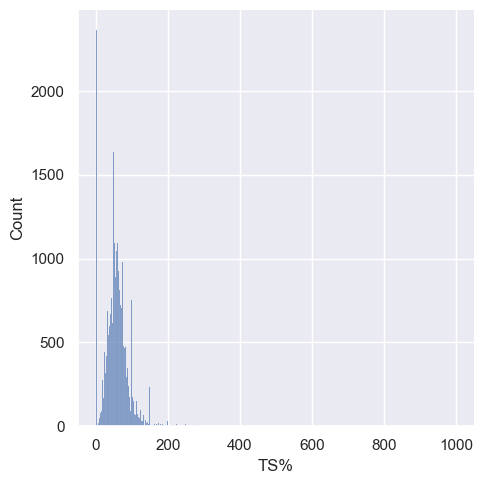

In [326]:
# Plotting distribution of TS%s of players in the 2021-2022 season
sns.displot(df_groupby, x='TS%')

## Analyzing % of shots missed and made by distance

In [285]:
# Creating 2 distributions of shots made from distance and shots missed from distance
# final_df_copy.shotDistance = final_df_copy.shotDistance.round(1)
df_shot_made = final_df_copy[((final_df_copy.actionType != 'freethrow') & (final_df_copy.shotResult == 'Made'))][['shotDistance', 'shotResult', 'actionType']]
df_shot_missed = final_df_copy[((final_df_copy.actionType != 'freethrow') & (final_df_copy.shotResult == 'Missed'))][['shotDistance', 'shotResult', 'actionType']]
df_shots_combined = pd.concat([df_shot_made, df_shot_missed])
df_shots_combined = df_shots_combined[df_shots_combined.shotDistance <= 46.0]

In [286]:
df_shots_combined.shotDistance.max()
# df_shot_missed.shotDistance.min()

46.0

In [292]:
### Plotting charts for shot makes and miss distribution
import seaborn as sns

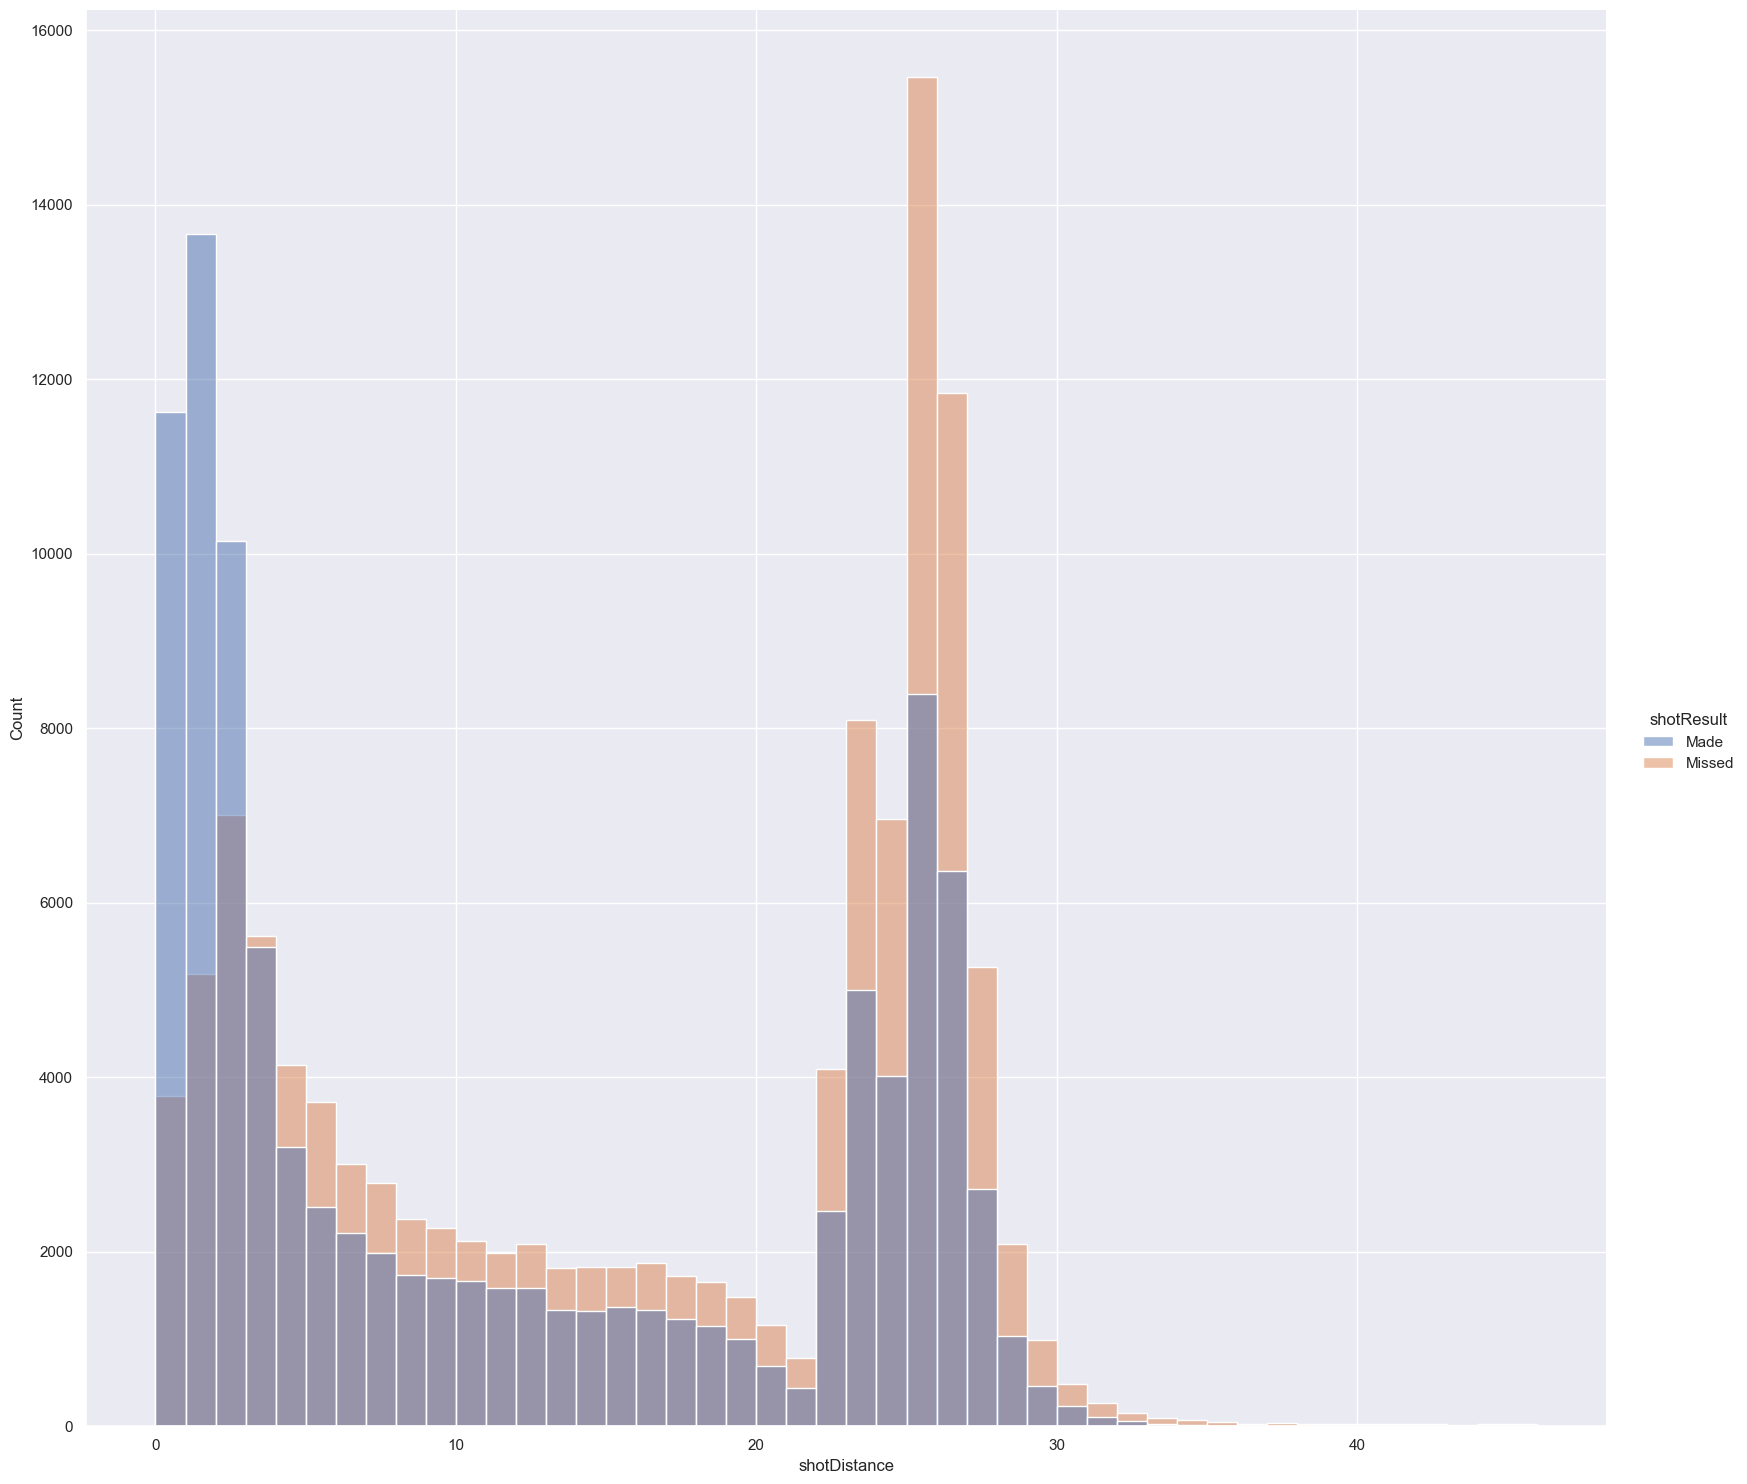

In [303]:
# sns.set(rc={'figure.figsize':(100,100)})
sns.displot(df_shots_combined,x='shotDistance', binwidth=1, hue='shotResult', height=15, aspect=1.10);

# Get x axis to show ticks every 2 feet

In [26]:
#Notes for to dos for this data set
# --What duo had the most assits to dunks in the NBA
# -- Most points in the clutch (under 3 minutes left when a game is within 5 points)
# -- Teams shooting % 2PT vs 3PT
# --best assist to turn over ratio
# -- distribution of made shots per team
# do one of those attribute hexagon charts where I plot 3pt, 2pt (type of 2 pt), and free throw % of each team


# Done---------------->
# --Calculate true shooting % of all players? using apply? or creating a function... probably this
#     #TS% - True Shooting Percentage; the formula is PTS / (2 * TSA). True shooting percentage is a measure of shooting efficiency that takes into account field goals, 3-point field goals, and free throws.
#     #TSA - True Shooting Attempts; the formula is FGA + 0.44 * FTA.

# --Look at % of makes of shots based on distance



#############################################################################
# """
# Add Stats around TS and other stats like variability and a distribution curve
# Plot it againts league average 
# Grab players that exhibit the most varibaility or the least
# """
#############################################################################

#### - Might have to seperate TIMEACTUAL field into date and time

## THIS IS ANALYSIS

In [27]:
#Looking at shots taken from rounded distances
final_df_copy.loc[:,['shotDistance']].round().value_counts()#.sort_index()

shotDistance
26.0            22892
2.0             19249
25.0            18937
1.0             16445
3.0             13577
                ...  
82.0                1
83.0                1
84.0                1
88.0                1
89.0                1
Length: 87, dtype: int64

In [28]:
#breaking down shot distance and the % of total shots made from the distance
final_df_copy.loc[:, ['shotResult']].value_counts()

shotResult
Made          141587
Missed        128907
dtype: int64

In [29]:
final_df_copy['actionType'].unique()

array(['period', 'jumpball', '3pt', 'rebound', '2pt', 'foul', 'freethrow',
       'turnover', 'timeout', 'stoppage', 'block', 'substitution',
       'steal', 'violation', 'instantreplay', 'game', 'memo', 'ejection'],
      dtype=object)

In [30]:
#pulling rows where actionType = 'block'
final_df_copy[final_df_copy.actionType == 'block']

,actionNumber,clock,timeActual,period,periodType,actionType,subType,qualifiers,personId,x,y,possession,scoreHome,scoreAway,edited,orderNumber,xLegacy,yLegacy,isFieldGoal,side,description,personIdsFilter,teamId,teamTricode,descriptor,jumpBallRecoveredName,jumpBallRecoverdPersonId,playerName,playerNameI,jumpBallWonPlayerName,jumpBallWonPersonId,jumpBallLostPlayerName,jumpBallLostPersonId,shotDistance,shotResult,shotActionNumber,reboundTotal,reboundDefensiveTotal,reboundOffensiveTotal,pointsTotal,assistPlayerNameInitial,assistPersonId,assistTotal,officialId,foulPersonalTotal,foulTechnicalTotal,foulDrawnPlayerName,foulDrawnPersonId,turnoverTotal,blockPlayerName,blockPersonId,stealPlayerName,stealPersonId,value,gameid,period_to_time
51,71,PT05M51.00S,2022-04-10T19:53:02.1Z,1,REGULAR,block,NaN,[],203991,NaN,NaN,1610612745,13,20,2022-04-10T19:53:04Z,690000,NaN,NaN,0,None,C. Capela BLOCK (1 BLK),[203991],1.610613e+09,ATL,NaN,NaN,NaN,Capela,C. Capela,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0022101221,0
64,86,PT04M08.00S,2022-04-10T19:55:13.0Z,1,REGULAR,block,NaN,[],1629726,NaN,NaN,1610612737,15,25,2022-04-10T19:55:17Z,840000,NaN,NaN,0,None,G. Mathews BLOCK (1 BLK),[1629726],1.610613e+09,HOU,NaN,NaN,NaN,Mathews,G. Mathews,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0022101221,0
115,144,PT00M02.10S,2022-04-10T20:05:35.0Z,1,REGULAR,block,NaN,[],1628021,NaN,NaN,1610612737,24,35,2022-04-10T20:06:47Z,1430000,NaN,NaN,0,None,D. Nwaba BLOCK (1 BLK),[1628021],1.610613e+09,HOU,NaN,NaN,NaN,Nwaba,D. Nwaba,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0022101221,0
261,319,PT10M38.00S,2022-04-10T20:51:18.6Z,3,REGULAR,block,NaN,[],1630256,NaN,NaN,1610612737,64,73,2022-04-10T20:51:21Z,3170000,NaN,NaN,0,None,J. Tate BLOCK (1 BLK),[1630256],1.610613e+09,HOU,NaN,NaN,NaN,Tate,J. Tate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0022101221,24
274,333,PT09M37.00S,2022-04-10T20:52:46.7Z,3,REGULAR,block,NaN,[],1630578,NaN,NaN,1610612737,66,73,2022-04-10T20:52:49Z,3310000,NaN,NaN,0,None,A. Sengun BLOCK (1 BLK),[1630578],1.610613e+09,HOU,NaN,NaN,NaN,Sengun,A. Sengun,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0022101221,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
691748,547,PT09M34.00S,2021-10-20T01:31:36.3Z,4,REGULAR,block,NaN,[],1626192,NaN,NaN,1610612751,99,90,2021-10-20T01:31:39Z,5410000,NaN,NaN,0,None,P. Connaughton BLOCK (1 BLK),[1626192],1.610613e+09,MIL,NaN,NaN,NaN,Connaughton,P. Connaughton,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0022100001,36
691773,578,PT07M46.00S,2021-10-20T01:37:35.2Z,4,REGULAR,block,NaN,[],1629670,NaN,NaN,1610612751,106,93,2021-10-20T01:37:38Z,5680000,NaN,NaN,0,None,J. Nwora BLOCK (1 BLK),[1629670],1.610613e+09,MIL,NaN,NaN,NaN,Nwora,J. Nwora,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0022100001,36
691786,595,PT06M45.00S,2021-10-20T01:40:09.9Z,4,REGULAR,block,NaN,[],203507,NaN,NaN,1610612751,112,95,2021-10-20T01:40:13Z,5850000,NaN,NaN,0,None,G. Antetokounmpo BLOCK (2 BLK),[203507],1.610613e+09,MIL,NaN,NaN,NaN,Antetokounmpo,G. Antetokounmpo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0022100001,36
691804,613,PT05M14.00S,2021-10-20T01:45:13.8Z,4,REGULAR,block,NaN,[],201142,NaN,NaN,1610612749,112,95,2021-10-20T01:45:17Z,6030000,NaN,NaN,0,None,K. Durant BLOCK (2 BLK),[201142],1.610613e+09,BKN,NaN,NaN,NaN,Durant,K. Durant,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [31]:
#take shotDistance, actionType is 2pt and 3pt, shotResult is Missed or Made
all_actions = pd.DataFrame(final_df_copy.loc[:, ["shotDistance", "actionType", "shotResult"]])

In [32]:
all_actions

,shotDistance,actionType,shotResult
0,NaN,period,NaN
1,NaN,jumpball,NaN
2,22.72,3pt,Missed
3,NaN,rebound,NaN
4,26.48,3pt,Made
...,...,...,...
691870,NaN,turnover,NaN
691871,29.71,3pt,Missed
691872,NaN,rebound,NaN
691873,NaN,period,NaN


In [33]:
shots_df = all_actions[(all_actions.shotResult.isin(['Missed', 'Made'])) & (all_actions.actionType.isin(['2pt', '3pt']))]

In [34]:
shots_df

,shotDistance,actionType,shotResult
2,22.72,3pt,Missed
4,26.48,3pt,Made
5,18.69,2pt,Made
6,19.20,2pt,Missed
8,5.10,2pt,Missed
...,...,...,...
691862,6.99,2pt,Missed
691864,0.00,2pt,Missed
691867,1.31,2pt,Made
691868,26.60,3pt,Missed


In [35]:
shots_df.sort_index(axis = 1, inplace = True)
shots_df = shots_df.round()

C:\Users\zman7\AppData\Local\Temp\ipykernel_15316\717320966.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shots_df.sort_index(axis = 1, inplace = True)


In [36]:
#shots_df.shotResult.replace(['Missed', 0], ['Made', 1])
shots_df['shotResult'] = shots_df.shotResult.replace(['Missed','Made'], [0, 1])

In [37]:
shots_df.shotResult.value_counts()

0    116783
1     99930
Name: shotResult, dtype: int64

In [38]:
def percentcalc(x):
    for i in shots_df[shots_df.shotResult]:
        if shots_df[shots_df.shotResult == 'Made']:
            return 1
        else:
            return 0

In [39]:
# shots_df.map(percentcalc)

In [42]:
# shots_grouped.shotResult.sum()

## Analyzing what players has the most assits to a dunk 

In [ ]:
#looking into what player has assisted the most dunks in the nba (or per team)
assists = final_df[(final_df.subType == 'DUNK') & (final_df.periodType == 'REGULAR')].loc[:,['assistPlayerNameInitial','playerNameI','teamTricode', 'teamId' ]]

In [ ]:
#adding new col with combined player
assists = assists[pd.notnull(assists.assistPlayerNameInitial)]

In [ ]:
assists['assistor-assiste'] = assists.assistPlayerNameInitial + '  to  ' + assists.playerNameI  

In [41]:
# assists.columns()

In [ ]:
assistsfinal = assists.loc[: ,['teamTricode','assistor-assiste']].sort_values(by=['teamTricode'])

In [ ]:
assists_grouped = assistsfinal.groupby(['teamTricode','assistor-assiste'])['assistor-assiste'].count()

In [ ]:
assists_grouped

teamTricode  assistor-assiste              
ATL          B. Bogdanovic  to  C. Capela      10
             B. Bogdanovic  to  J. Collins      5
             B. Bogdanovic  to  K. Huerter      1
             B. Bogdanovic  to  N. Knight       3
             B. Bogdanovic  to  O. Okongwu      2
                                               ..
WAS          R. Westbrook  to  R. Hachimura    31
             R. Westbrook  to  R. Lopez        13
             R. Westbrook  to  T. Bryant        6
             T. Brown Jr.  to  R. Westbrook     1
             T. Brown Jr.  to  T. Bryant        1
Name: assistor-assiste, Length: 2248, dtype: int64